# Implementing Hyperbolic K-Means
`Drew Wilimitis`

In this notebook, I attempt to extend the idea of Poincaré embeddings and hyperbolic multidimensional scaling by exploiting the representational capacity of these embeddings to apply clustering in hyperbolic space. Given that K-means is a relatively simpler clustering algorithm with existing implementations in the standard Euclidean space, I test an implementation of K-means clustering in  hyperbolic space. <br>
<br>
My hypothesis is that given the demonstrated success of hyperbolic embeddings in learning hierarchical relationships, applying hyperbolic clustering algorithms to hyperbolically embedded data may outperform clustering in euclidean space, specifically on hierarchical datasets.

## Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

## Load libraries and helper functions

In [10]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# import utility functions from repository
import sys
# path to directory containing utils.py file
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning'
sys.path.append(my_path)
from utils import *
from poincare_kmeans import HyperbolicKMeans

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [13]:
# plot clustering results in poincare disk
def plot_poincare(data, y, centroids, n_clusters, height=5, width=12, euclidean=False):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.scatter(data[:, 0], data[:, 1], c='black')
    plt.subplot(122)
    colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
    for i in range(n_clusters):
        if euclidean:
            plt.scatter(data[(y == i), 0], data[(y == i), 1], c = colors[i], 
                    alpha=0.8, edgecolors='w', linewidth=2)
            plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c = colors[i], 
                        edgecolor='black', linewidth=2);
            plt.suptitle('Euclidean K-Means Clustering vs. Original Data', size=14);
        else:
            plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                        alpha=0.8, edgecolors='w', linewidth=2)
            plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c = colors[i],
                        edgecolor='black', linewidth=2);
            plt.suptitle('Poincaré K-Means Clustering vs. Original Data', size=14);
    plt.show();

In [14]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(hyperboloid_dot(pt, pt), -1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


##  Zachary karate club network

In [4]:
karate_df = pd.read_csv('../data/ucidata-zachary/out.tsv', delimiter=' ')
u = karate_df.iloc[:, 0]
v = karate_df.iloc[:, 1]
n = len(np.unique(karate_df))
num_edges = len(u)

In [5]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='../data/ucidata-zachary/out.tsv', delimiter=' ')
model = PoincareModel(train_data=relations)

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=10
epochs=100
print_every=500
batch_size=10
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 78 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=10
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished


In [6]:
# vectors from the PoincareModel instance, in the commonly used word2vec format
model.kv.save_word2vec_format(os.path.join('models','karate_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','karate_vectors'))

emb = pd.read_table('models/karate_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

INFO:gensim.models.utils_any2vec:storing 34x2 projection weights into models\karate_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\karate_vectors
INFO:gensim.models.utils_any2vec:loaded (34, 2) matrix from models\karate_vectors


(34, 2)

Cluster variance:  1.4820558439916787
Inertia (poincaré dist):  46.96344091180727


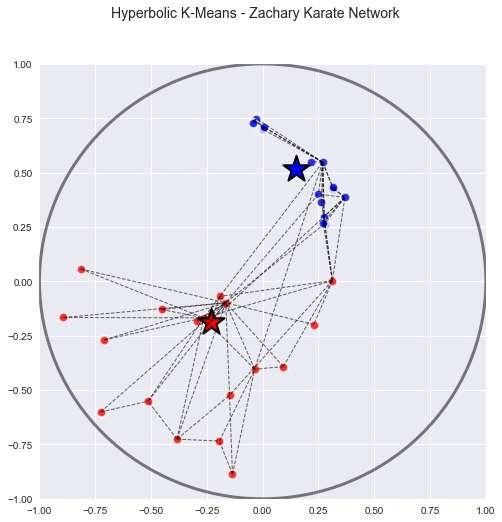

In [9]:
data = emb_data
hkmeans = HyperbolicKMeans(n_clusters=2)
y = hkmeans.fit_predict(data, max_epochs=15)
centroids = hkmeans.centroids
plt.figure(figsize=(8,8))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
n_clusters=2
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == u[i]), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == v[i]), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.6)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Hyperbolic K-Means - Zachary Karate Network', size=14);
print('Cluster variance: ', hkmeans.variances)
print('Inertia (poincaré dist): ', hkmeans.inertia_)
plt.show();

### NCAA football teams

In [104]:
import networkx as nx
G = nx.read_gml('football.gml', label='id')
football_df = pd.DataFrame(np.array(G.nodes()))

u = np.array([x[0] for x in list(G.edges())])
v = np.array([x[1] for x in list(G.edges())])

football_df = pd.DataFrame(u, columns=['u'])
football_df['v'] = v
football_df.to_csv('football_relations.csv', index=False)

In [844]:
n = len(np.unique(football_df))
num_edges = len(u)
relations = PoincareRelations(file_path='football_relations.csv', delimiter=',')

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=100
print_every=1000
batch_size=10

model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)
model.kv.save_word2vec_format(os.path.join('models','football_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','football_vectors'))

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 614 relations from train data, 117 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 614 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 117x2 projection weights into models\football_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\football_vectors
INFO:gensim.models.utils_any2vec:loaded (117, 2) matrix from models\football_vectors


In [105]:
emb = pd.read_csv('models/football_vectors', delimiter=' ')
emb.head()
emb.shape

emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
emb = emb.iloc[:-2, :]

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

,117,2
0,0.421881,0.870230
1,-0.743041,0.566695
104,0.297090,0.532553
2,0.649730,-0.685645
3,0.163925,-0.912610


(117, 2)

(115, 2)

In [107]:
data = emb_data
n_clusters=12
pkmeans = PoincareKMeans(n_clusters=n_clusters)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids

G = nx.read_gml('football.gml', label='id')
teams = []
for i in range(emb.shape[0]):
    teams.append(G.node[i]['label'])
ncaa_labels = []
for i in range(emb.shape[0]):
    ncaa_labels.append(G.node[i]['value'])
teams = np.array(teams)
ncaa_labels = np.array(ncaa_labels)

football_dict = {}
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[teams[i]] = np.argwhere(y[i] == 1)[0][0]

for i in range(emb.shape[0]):
    football_dict[teams[i]] = emb_data[i]

def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

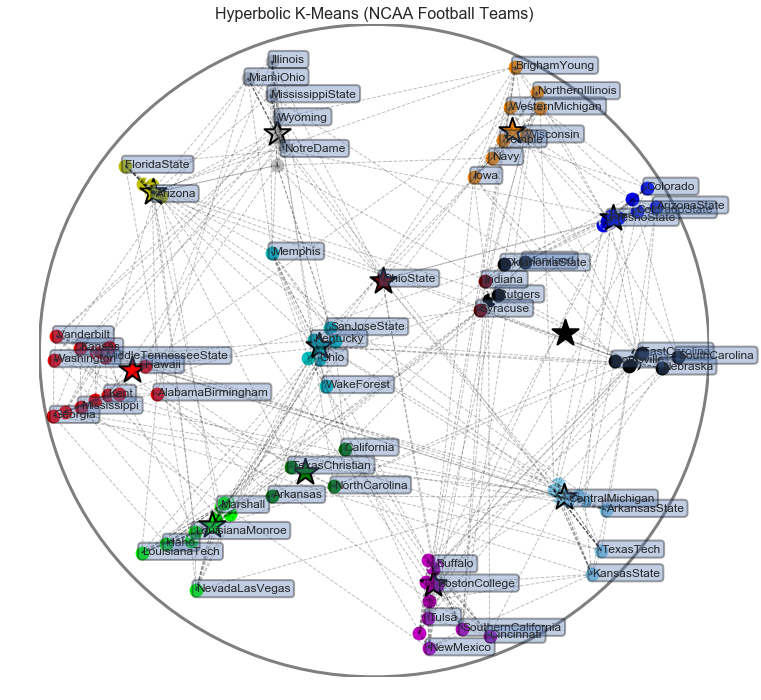

In [108]:
fig = plt.figure(figsize=(12,12))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.grid('off')
plt.axis('off')
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
n_clusters=12
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                edgecolors='w', linewidth=2, s=250)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.25)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

label_frac = 0.001
plot_frac = 1
embed_vals = np.array(list(football_dict.values()))
keys = list(football_dict.keys())
min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
labeled_vals = np.array([2*embed_vals.max(axis=0)])
n = int(plot_frac*len(embed_vals))
for i in np.random.permutation(len(embed_vals))[:n]:
    _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
    if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
        continue
    else:
        props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.35)
        _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0],
                    size=10, fontsize=12, verticalalignment='top', bbox=props)
        labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
plt.title('Hyperbolic K-Means (NCAA Football Teams)', size=16)
#plt.savefig('../images/ncaa_kmeans.png')
plt.show();

## Enron Email Corpus

In [39]:
emails = pd.read_table('emails.txt', delimiter=' ', header=None)
emails.iloc[:, 1:].to_csv('enron_relations.csv', index=False)

employees = pd.read_table('employees.txt', delimiter='\t', header=None)
employees = employees.reset_index()
employees.columns = ['emp_index', 'emp_email', 'emp_info']

In [40]:
attributes = employees.emp_info.values
first_names = [x.split(' ')[0] for x in attributes]
last_names = []
for attr in attributes:
    if len(attr.split(' ')) > 1:
        last_names.append(attr.split(' ')[1])
    else:
        last_names.append('NA')

titles = ['CEO', 'COO', 'President', 'Vice President', 'Director', 'Manager', 'Trader', 'Employee']
attr_list = [x.split(' ') for x in attributes]
emp_titles = []
for l in attr_list:
    items = [x for x in l if x in titles]
    if len(items) == 0:
        emp_titles.append('NA')
    else:
        emp_titles.append([x for x in l if x in titles][0])

employees['first'] = np.array(first_names)
employees['last'] = np.array(last_names)
employees['title'] = np.array(emp_titles)
employees.head()

,emp_index,emp_email,emp_info,first,last,title
0,0,albert.meyers,Albert Meyers Employee Specialist,Albert,Meyers,Employee
1,1,a..martin,Thomas Martin Vice President,Thomas,Martin,President
2,2,andrea.ring,Andrea Ring N/A,Andrea,Ring,NA
3,3,andrew.lewis,Andrew Lewis Director,Andrew,Lewis,Director
4,4,andy.zipper,Andy Zipper Vice President Enro...,Andy,Zipper,President


In [340]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='enron_relations.csv', delimiter=',')
model = PoincareModel(train_data=relations)

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=50
print_every=1000
batch_size=100
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 125410 relations from train data, 184 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 125410 relations from train data, 184 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 125410 relations for 50 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #99900-#100000, loss: 125.03
INFO:gensim.models.poincare:time taken for 100000 examples: 47.91 s, 2087.27 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #99900-#100000, loss: 82.23
INFO:gensim.models.poincare:time taken for 100000 examples: 43.94 s, 2275.66 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #99900-#100000, loss: 74.87
INFO:

INFO:gensim.models.poincare:time taken for 100000 examples: 48.55 s, 2059.78 examples / s
INFO:gensim.models.poincare:training on epoch 34, examples #99900-#100000, loss: 69.42
INFO:gensim.models.poincare:time taken for 100000 examples: 47.42 s, 2108.87 examples / s
INFO:gensim.models.poincare:training on epoch 35, examples #99900-#100000, loss: 68.96
INFO:gensim.models.poincare:time taken for 100000 examples: 43.69 s, 2288.61 examples / s
INFO:gensim.models.poincare:training on epoch 36, examples #99900-#100000, loss: 68.98
INFO:gensim.models.poincare:time taken for 100000 examples: 42.95 s, 2328.24 examples / s
INFO:gensim.models.poincare:training on epoch 37, examples #99900-#100000, loss: 69.17
INFO:gensim.models.poincare:time taken for 100000 examples: 49.35 s, 2026.33 examples / s
INFO:gensim.models.poincare:training on epoch 38, examples #99900-#100000, loss: 69.17
INFO:gensim.models.poincare:time taken for 100000 examples: 50.00 s, 2000.03 examples / s
INFO:gensim.models.poinca

In [41]:
# Saves only the vectors from the PoincareModel instance, in the commonly used word2vec format
import os
emb = pd.read_table('models/enron_vectors', delimiter=' ')
emb = emb.reset_index()

emb.columns = ['node', 'x', 'y']
x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape
emails.columns = ['time', 'sender', 'recipient']
u = list(emails.sender)
v = list(emails.recipient)
emb.head()

(184, 2)

,node,x,y
0,178,-0.198446,0.200250
1,63,-0.876846,0.295566
2,58,-0.729912,0.166571
3,169,-0.705179,-0.700292
4,146,-0.605535,0.270690


In [42]:
data = emb_data
n_clusters=6
pkmeans = PoincareKMeans(n_clusters=n_clusters)
y = pkmeans.fit_predict(data, max_epochs=10)
centroids = pkmeans.centroids

names = employees['first'].values + ' ' + employees['last'].values
enron_dict = {}
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[names[i]] = np.argwhere(y[i] == 1)[0][0]

for i in range(emb.shape[0]):
    enron_dict[names[i]] = emb_data[i]

def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

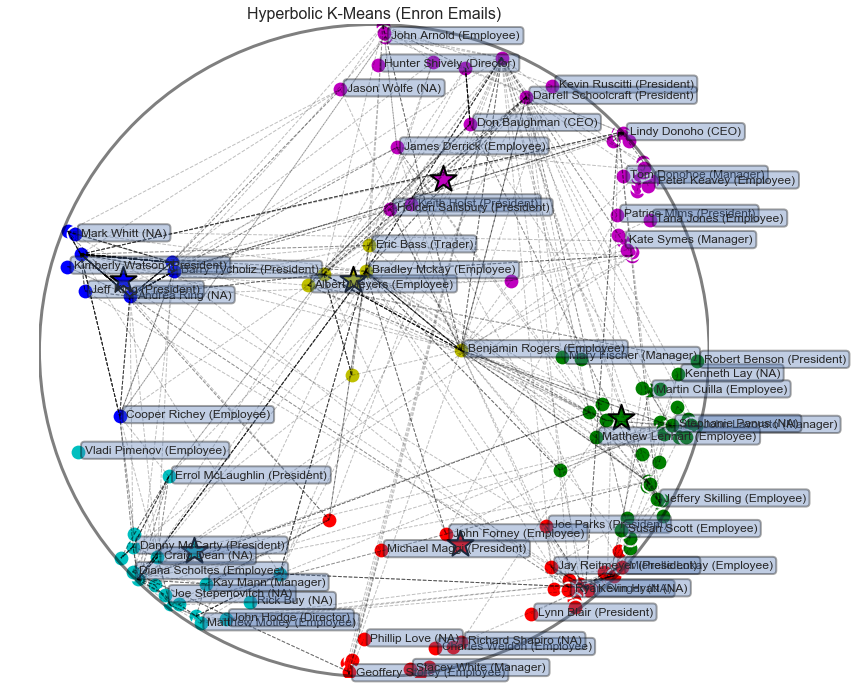

In [43]:
fig = plt.figure(figsize=(12,12))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.grid('off')
plt.axis('off')
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
n_clusters=6
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                edgecolors='w', linewidth=2, s=250)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u))[::100]:
    x1 = emb.loc[(emb.node == u[i]), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == v[i]), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.25)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

label_frac = 0.001
plot_frac = 1
embed_vals = np.array(list(enron_dict.values()))
keys = list(enron_dict.keys())
min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
labeled_vals = np.array([2*embed_vals.max(axis=0)])
n = int(plot_frac*len(embed_vals))
for i in np.random.permutation(len(embed_vals))[:n]:
    _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
    if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
        continue
    else:
        props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.35)
        _ = ax.text(embed_vals[i][0]+0.02, embed_vals[i][1]+0.02, 
                    s=keys[i].split('.')[0] + ' (' + emp_titles[i] + ')',
                    size=10, fontsize=12, verticalalignment='top', bbox=props)
        labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
plt.title('Hyperbolic K-Means (Enron Emails)', size=16)
#plt.savefig('ncaa_kmeans.png')
plt.show();

## WordNET Mammals Subtree

### Train the poincaré embedding with gensim

In [240]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='wordnet_mammal_hypernyms.tsv', delimiter='\t')
model = PoincareModel(train_data=relations)`

size=2
burn_in=0
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=100
print_every=500
batch_size=10
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 7724 relations from train data, 1182 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 7724 relations from train data, 1182 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 7724 relations for 100 epochs and 0 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #4990-#5000, loss: 27.31
INFO:gensim.models.poincare:time taken for 5000 examples: 1.70 s, 2937.94 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #4990-#5000, loss: 25.89
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3088.89 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #4990-#5000, loss: 24.47
INFO:gensim.models.poin

INFO:gensim.models.poincare:training on epoch 46, examples #4990-#5000, loss: 11.85
INFO:gensim.models.poincare:time taken for 5000 examples: 1.59 s, 3139.22 examples / s
INFO:gensim.models.poincare:training on epoch 47, examples #4990-#5000, loss: 11.46
INFO:gensim.models.poincare:time taken for 5000 examples: 1.69 s, 2957.68 examples / s
INFO:gensim.models.poincare:training on epoch 48, examples #4990-#5000, loss: 11.44
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3090.93 examples / s
INFO:gensim.models.poincare:training on epoch 49, examples #4990-#5000, loss: 11.26
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3081.36 examples / s
INFO:gensim.models.poincare:training on epoch 50, examples #4990-#5000, loss: 11.21
INFO:gensim.models.poincare:time taken for 5000 examples: 1.71 s, 2923.30 examples / s
INFO:gensim.models.poincare:training on epoch 51, examples #4990-#5000, loss: 11.36
INFO:gensim.models.poincare:time taken for 5000 examples: 1.6

INFO:gensim.models.poincare:time taken for 5000 examples: 1.68 s, 2984.21 examples / s
INFO:gensim.models.poincare:training on epoch 95, examples #4990-#5000, loss: 7.90
INFO:gensim.models.poincare:time taken for 5000 examples: 1.57 s, 3175.07 examples / s
INFO:gensim.models.poincare:training on epoch 96, examples #4990-#5000, loss: 7.85
INFO:gensim.models.poincare:time taken for 5000 examples: 1.64 s, 3043.88 examples / s
INFO:gensim.models.poincare:training on epoch 97, examples #4990-#5000, loss: 7.94
INFO:gensim.models.poincare:time taken for 5000 examples: 1.61 s, 3111.96 examples / s
INFO:gensim.models.poincare:training on epoch 98, examples #4990-#5000, loss: 7.67
INFO:gensim.models.poincare:time taken for 5000 examples: 1.63 s, 3075.60 examples / s
INFO:gensim.models.poincare:training on epoch 99, examples #4990-#5000, loss: 7.71
INFO:gensim.models.poincare:time taken for 5000 examples: 1.69 s, 2954.25 examples / s
INFO:gensim.models.poincare:training on epoch 100, examples #49

In [52]:
# Saves only the vectors from the PoincareModel instance, in the commonly used word2vec format
emb = pd.read_csv('models/test_vectors.csv', delimiter=' ')
emb = emb.reset_index()
x = emb.loc[:, '1182'].values
y = emb.loc[:, '2'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

(1182, 2)

In [58]:
data = emb_data
pkmeans = PoincareKMeans(n_clusters=6)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids

mammal_dict = {}
mammals = emb['index'].values
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[mammals[i]] = np.argmax(y[i])

for i in range(emb.shape[0]):
    mammal_dict[mammals[i]] = emb_data[i]

def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

In [76]:
def plot_embedding(embedding_dict, label_frac=0.001, plot_frac=0.6, title=None, 
                   save_fig=False):
    colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']
    fig = plt.figure(figsize=(9,9))
    plt.grid('off')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.axis('off')
    ax = plt.gca()
    embed_vals = np.array(list(embedding_dict.values()))
    #plt.xlim([embed_vals.min(0)[0],embed_vals.max(0)[0]])
    #plt.ylim([embed_vals.min(0)[1],embed_vals.max(0)[1]])
    keys = list(embedding_dict.keys())
    min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
    labeled_vals = np.array([2*embed_vals.max(axis=0)])
    groups = [keys[i] for i in np.argsort(np.linalg.norm(embed_vals, axis=1))][:10]
    groups.insert(0, 'mammal.n.01')
    for key in groups:
        if np.min(dist_squared(embedding_dict[key], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.scatter(embedding_dict[key][0], embedding_dict[key][1], s=40, c=colors[label_dict[key]])
            props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.5)
            _ = ax.text(embedding_dict[key][0], embedding_dict[key][1]+0.01, s=key.split('.')[0], 
                        size=10, fontsize=12, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embedding_dict[key]))
    n = int(plot_frac*len(embed_vals))
    for i in np.random.permutation(len(embed_vals))[:n]:
        _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
        if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0], 
                        size=9, fontsize=11, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    if title != None:
        plt.title(title, size=16)
    if save_fig:
        plt.savefig('../images/mammals_kmeans.png')

(82, 2)


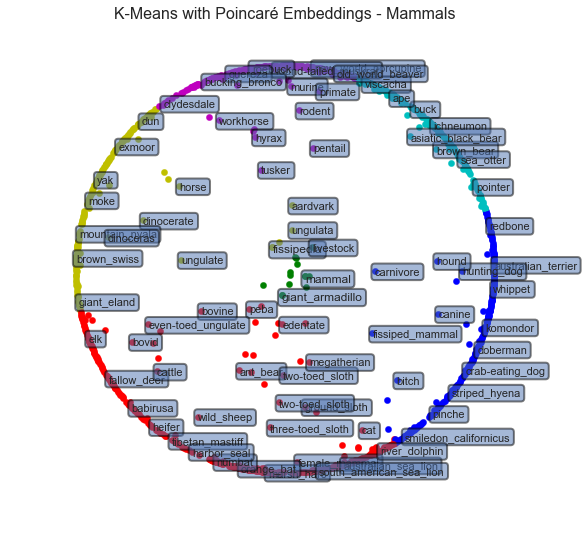

In [77]:
plot_embedding(mammal_dict, plot_frac=1, label_frac=0.003,
               title='K-Means with Poincaré Embeddings - Mammals', save_fig=True)

# Supervised Learning Examples

We now adapt the hyperbolic KMeans algorithm for supervised learning, where the K centroids are produced by a random training subset and classification predictions are made on a separate holdout test set. 

In [80]:
class PKMeansClassifier():
    """
    Perform supervised K-Means clustering in hyperbolic space.
    """
    
    def __init__(self,n_clusters=8,n_init=20,max_iter=300,tol=1e-8,verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose =  verbose
        self.labels = None
        self.cluster_centers_ = None
        
    def init_centroids(self, radius=0.3):
        # randomly sample starting points on small uniform ball
        theta = np.random.uniform(0, 2*np.pi, self.n_clusters)
        u = np.random.uniform(0, radius, self.n_clusters)
        r = np.sqrt(u)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        centers = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
        self.centroids = centers
        
    def init_assign(self, y):
        # cluster assignments as indicator matrix
        assignments = np.zeros((self.n_samples, self.n_clusters))
        for i in range(self.n_samples):
            # assign to classes with ground truth input labels
            assignments[i][y[i]] = 1
        self.assignments = assignments
        
    def update_centroids(self, X):
        """Updates centroids with Fréchet means in Hyperboloid model
        Parameters
        ----------
        X : array of shape (n_samples, dim) with input data.
        First convert X to hyperboloid points
        """
        dim = X.shape[1]
        new_centroids = np.empty((self.n_clusters, dim)) 
        H = poincare_pts_to_hyperboloid(X)
        for i in range(self.n_clusters):
            if np.sum(self.assignments[:, i] ==1) == 0:
                new_centroids[i] = self.centroids[i]
            else:
                # find subset of observations in cluster
                H_k = H[self.assignments[:, i] == 1]
                theta_k = poincare_pt_to_hyperboloid(self.centroids[i])
                # solve for frechet mean
                fmean_k = frechet_mean(theta_k, H_k, alpha=0.1)
                # convert back to Poincare disk
                new_centroids[i] = hyperboloid_pt_to_poincare(fmean_k)
        self.centroids = new_centroids
        
    def cluster_var(self, X):
        n = self.centroids.shape[0]
        var_C = []
        for i in range(n):
            var_C.append(np.mean(np.array([poincare_dist(self.centroids[i], x) for x in X])))
        self.variances = np.sort(var_C)[-2]
    
    def fit(self, X, y, max_epochs=10):
        """
        Apply K means algorithm in the Poincaré disk for input data X
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        """
        self.fit_predict(X, y, max_epochs=max_epochs)
        return self

    def fit_predict(self, X, y, max_epochs=40, verbose=False):
        """
        Fit the K centroids from X, and return the class assignments by nearest centroid
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        
        # make sure X within poincaré ball
        #X = Normalizer().fit_transform(X)
        if (norm(X, axis=1) > 1).any():
            X = X / (np.max(norm(X, axis=1)))
        
        # initialize random centroids and assignments
        self.n_samples = X.shape[0]
        self.init_centroids()
        self.init_assign(y)
        
        # loop through the assignment and update steps
        for j in range(max_epochs):
            self.inertia_ = 0
            self.update_centroids(X)
            for i in range(self.n_samples):
                # zero out current cluster assignment
                #self.assignments[i, :] = np.zeros((1, self.n_clusters))
                # find closest centroid (in Poincare disk)
                centroid_distances = np.array([poincare_dist(X[i], centroid) for centroid in self.centroids])
                cx = np.argmin(centroid_distances)
                self.inertia_ += centroid_distances[cx]**2
                #self.assignments[i][cx] = 1
            if verbose:
                print('Epoch ' + str(j) + ' complete')
                print(self.centroids)
        self.labels = np.argmax(self.assignments, axis=1)
        self.cluster_var(X)
        return self.assignments
    
    def predict(self, X):
        """
        Predict class labels for given data points by nearest centroid rule
        Parameters
        ----------
        X : array, shape (n_samples, n_features). Observations to be assigned to the
        class represented by the nearest centroid.
        """
        # zero out current cluster assignment
        n = X.shape[0]
        labels = np.zeros((n, self.n_clusters))
        # find closest centroid (in Poincare disk)
        for i in range(n):
            centroid_distances = np.array([poincare_dist(X[i], centroid) for centroid in self.centroids])
            cx = np.argmin(centroid_distances)
            labels[i][cx] = 1
        return labels

## Karate Club

In [97]:
emb = pd.read_table('models/karate_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
          1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1])
y_true = y_true[emb.node.values - 1]

(34, 2)

In [98]:
from sklearn.model_selection import train_test_split
X = emb_data
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.5) 

pk_clf = PKMeansClassifier(n_clusters=2)
pk_clf.fit(X_train, y_train)
np.allclose(pk_clf.labels,y_train)

y_pred = np.argmax(pk_clf.predict(X_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, zero_one_loss
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

True

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10

   micro avg       1.00      1.00      1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

1.0
0.0


## NCAA teams

In [109]:
emb = pd.read_table('models/football_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
emb = emb.iloc[:-2, :]
x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

# true class labels 
y_true = ncaa_labels
y_true = y_true[emb.node.values.astype('int')]

(115, 2)

In [111]:
from sklearn.model_selection import train_test_split
X = emb_data
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.5) 

pk_clf = PKMeansClassifier(n_clusters=12)
pk_clf.fit(X_train, y_train, max_epochs=4)
np.allclose(pk_clf.labels,y_train)

y_pred = np.argmax(pk_clf.predict(X_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, zero_one_loss
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

True

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         3
           6       0.56      0.56      0.56         9
           7       1.00      1.00      1.00         5
           8       0.00      0.00      0.00         6
           9       1.00      1.00      1.00         4
          10       0.22      0.40      0.29         5
          11       1.00      1.00      1.00         2

   micro avg       0.72      0.72      0.72        58
   macro avg       0.68      0.75      0.70        58
weighted avg       0.68      0.72      0.69        58

0.7241379310344828
0.27586206896551724


## Polbooks

In [113]:
pollbooks_df = pd.read_table('pollbooks/out.dimacs10-polbooks', delimiter='\t')
pollbooks_df = pollbooks_df.reset_index()
u = pollbooks_df.iloc[:, 0]
v = pollbooks_df.iloc[:, 1]
pollbooks_df.shape
pollbooks_df.columns = ['u', 'v']

n = len(np.unique(pollbooks_df))
num_edges = len(u)

pollbooks_df.to_csv('pollbooks_relations.csv', index=False)

(441, 2)

In [1101]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='pollbooks_relations.csv', delimiter=',')
model = PoincareModel(train_data=relations)

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=300
print_every=500
batch_size=10
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 442 relations from train data, 107 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 442 relations from train data, 107 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 442 relations for 300 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (300 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished


In [114]:
emb = pd.read_table('models/pollbooks_vectors', delimiter=' ')
emb = emb.reset_index()
emb = emb.iloc[:-2, :]
emb.columns = ['node', 'x', 'y']

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

(105, 2)

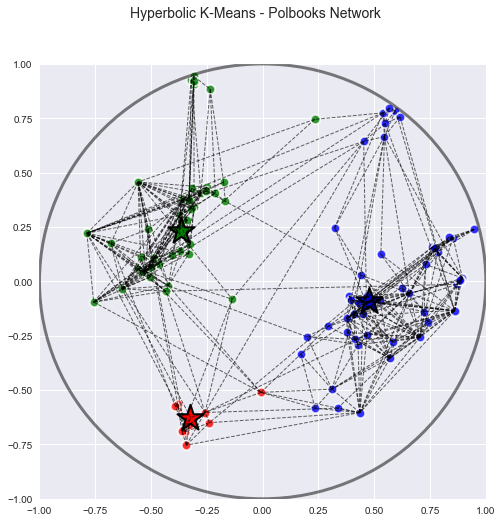

In [115]:
data = emb_data
pkmeans = PoincareKMeans(n_clusters=3)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids
plt.figure(figsize=(8,8))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
n_clusters=3
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.6)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Hyperbolic K-Means - Polbooks Network', size=14);
plt.show();

In [116]:
G = nx.read_gml('polbooks.gml.txt', label='id')
labels = []
for i in range(emb.shape[0]):
    labels.append(G.node[i]['value'])
labels = np.array(labels)
class_map = {'n': 0, 'c': 1, 'l': 2}
polbook_labels = np.array([class_map[x] for x in labels])

In [117]:
# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
y_true = polbook_labels
y_true = y_true[emb.node.values.astype('int')-1]

In [119]:
from sklearn.model_selection import train_test_split
X = emb_data
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.5) 

pk_clf = PKMeansClassifier(n_clusters=3)
pk_clf.fit(X_train, y_train)
np.allclose(pk_clf.labels,y_train)

y_pred = np.argmax(pk_clf.predict(X_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, zero_one_loss
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(zero_one_loss(y_test, y_pred))

True

              precision    recall  f1-score   support

           0       0.14      0.14      0.14         7
           1       0.76      1.00      0.86        25
           2       0.92      0.57      0.71        21

   micro avg       0.72      0.72      0.72        53
   macro avg       0.61      0.57      0.57        53
weighted avg       0.74      0.72      0.71        53

0.7169811320754716
0.28301886792452835


In [120]:
#from IPython.core.display import HTML

#def css_styling():
#    styles = open("../custom_style.css", "r").read()
#    return HTML(styles)
#css_styling()

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).